<a href="https://colab.research.google.com/github/antonKornilov1/some/blob/architecture3/Lenet_mnist_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np
import time

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

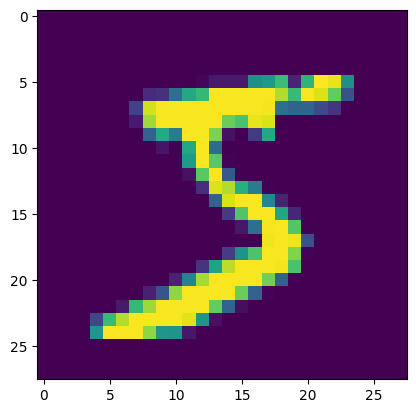

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1_1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.act1_1  = torch.nn.ReLU()

        self.conv1_1k = torch.nn.Conv2d(
            in_channels=6, out_channels=6, kernel_size=1) # добавляем свертку 1*1
        self.act1_1k  = torch.nn.ReLU()

        self.conv1_2 = torch.nn.Conv2d(6, 6, kernel_size=3, padding=1)
        self.act1_2 = torch.nn.ReLU()

        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = torch.nn.Conv2d(6, 16, kernel_size=3, padding=0)
        self.act2_1 = torch.nn.ReLU()

        self.conv2_1k = torch.nn.Conv2d(16, 16, kernel_size=1) # добавляем свертку 1*1
        self.act2_1k = torch.nn.ReLU();

        self.conv2_2 = torch.nn.Conv2d(16, 16, kernel_size=3, padding=0) # размер 10 на 10
        self.act2_2 = torch.nn.ReLU();

        self.pool2 = torch.nn.MaxPool2d(2, 2) # теперь размер 5 на 5

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):

        x = self.act1_1(self.conv1_1(x))
        x = self.act1_1k(self.conv1_1k(x))
        x = self.act1_2(self.conv1_2(x))
        x = self.pool1(x)

        x = self.act2_1(self.conv2_1(x))
        x = self.act2_1k(self.conv2_1k(x))
        x = self.act2_2(self.conv2_2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1) # flatten превращает 3д тензор признаков в вектор 5*5*16=400

        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

lenet5 = LeNet5()

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [12]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []
epoch_times = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(25):
    start_time = time.time()
    order = np.random.permutation(len(X_train))
    epoch_train_loss = 0
    batch_count = 0

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = lenet5.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

        epoch_train_loss += loss_value.item()
        batch_count += 1

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)
    train_loss_history.append(epoch_train_loss / batch_count)
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    # print(accuracy)
    print(f"Epoch {epoch}: Accuracy = {accuracy:.4f}, Time = {epoch_time:.2f}s")


Epoch 0: Accuracy = 0.9782, Time = 25.04s
Epoch 1: Accuracy = 0.9848, Time = 24.47s
Epoch 2: Accuracy = 0.9878, Time = 25.27s
Epoch 3: Accuracy = 0.9876, Time = 24.46s
Epoch 4: Accuracy = 0.9849, Time = 24.24s
Epoch 5: Accuracy = 0.9891, Time = 24.41s
Epoch 6: Accuracy = 0.9878, Time = 23.97s
Epoch 7: Accuracy = 0.9901, Time = 24.52s
Epoch 8: Accuracy = 0.9884, Time = 24.28s
Epoch 9: Accuracy = 0.9905, Time = 24.38s
Epoch 10: Accuracy = 0.9889, Time = 24.37s
Epoch 11: Accuracy = 0.9908, Time = 24.84s
Epoch 12: Accuracy = 0.9904, Time = 23.84s
Epoch 13: Accuracy = 0.9892, Time = 24.36s
Epoch 14: Accuracy = 0.9896, Time = 24.65s
Epoch 15: Accuracy = 0.9899, Time = 24.52s
Epoch 16: Accuracy = 0.9896, Time = 24.87s
Epoch 17: Accuracy = 0.9901, Time = 24.11s
Epoch 18: Accuracy = 0.9893, Time = 25.62s
Epoch 19: Accuracy = 0.9908, Time = 24.10s
Epoch 20: Accuracy = 0.9884, Time = 28.18s
Epoch 21: Accuracy = 0.9906, Time = 24.21s
Epoch 22: Accuracy = 0.9890, Time = 24.96s
Epoch 23: Accuracy = 

In [13]:
lenet5.forward(X_test)

tensor([[-14.8065,  -3.4796,  -1.7174,  ...,  18.1405, -14.4233,  -1.1955],
        [-16.4441,  -1.5520,  28.5464,  ..., -12.5874,  -6.2465, -10.6723],
        [-10.3703,  16.0389,  -7.2804,  ...,  -4.7735,  -5.9926, -10.6406],
        ...,
        [-31.3691, -13.8043, -14.1477,  ..., -26.9032,  -4.5737, -10.8957],
        [ -3.5820, -25.9954, -12.9911,  ..., -18.0739,  -3.6617,  -9.6554],
        [ -8.3491, -10.8645,  -5.0043,  ..., -23.6680,  -5.2003, -12.1960]],
       grad_fn=<AddmmBackward0>)

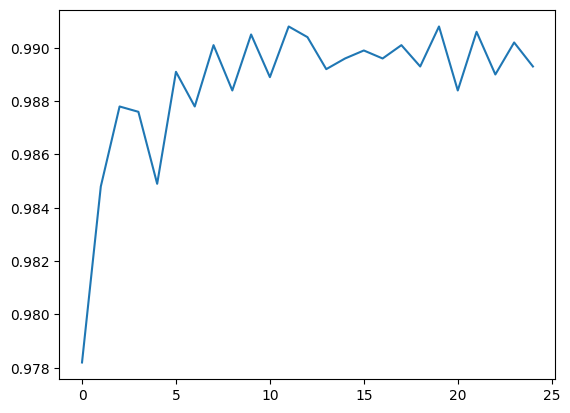

In [14]:
plt.plot(test_accuracy_history);

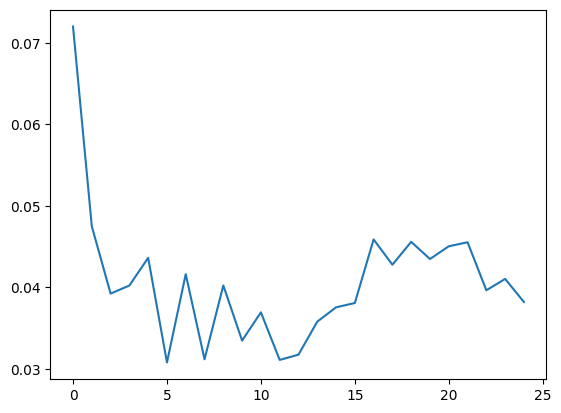

In [15]:
plt.plot(test_loss_history);

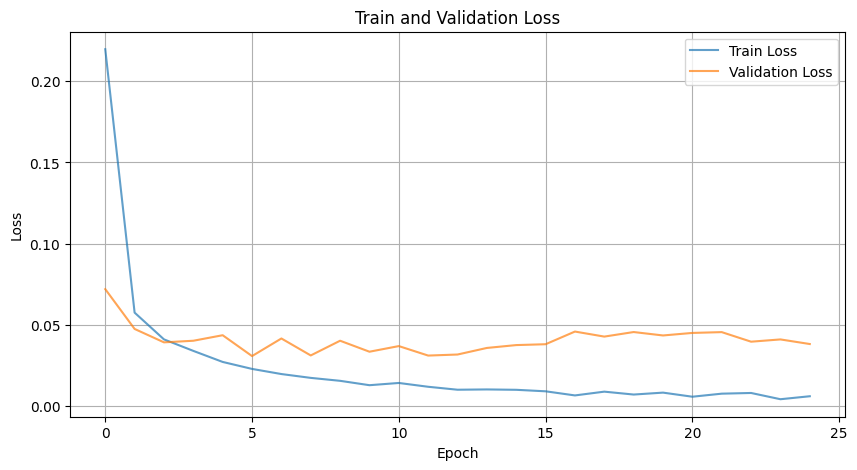

In [16]:
test_accuracy_history = [float(x) for x in test_accuracy_history]
test_loss_history = [float(x) for x in test_loss_history]

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss', alpha=0.7)
plt.plot(test_loss_history, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()